# Domain Specific RAG Evaluation for Chunking & Embedding Pipelines
* Notebook by Adam Lang
* Date: 1/22/2025


# Overview of more common chunking approaches
* Document Chunking usually entails chunking strategies such as:
  1. Fixed-Size
  2. "Context Aware"
    * Sentence splitting
      * Naive splitting (split by periods ".")
      * NLTK
      * spaCy
  3. Recursive splitting
    * Most common hierarchical and iterative chunking technique with the `RecursiveCharacterTextSplitter` from LangChain.
  4. Specialized chunking
    * Markdown
    * LaTex
  5. Semantic Chunking
    * Cosine Similarity used to create chunks based on semantic similarity.

* Sources:
  * [Pinecone](https://www.pinecone.io/learn/chunking-strategies/)

# Overview of Alternative Chunking Approaches
* A first step in building a RAG system is to decide how to load and split your documents before creating embeddings and loading them into a vector database.
* While there are some techniques such as:
  1. **Late Chunking**
    * In a nutshell, this means EMBED THE ENTIRE DOCUMENT BEFORE SPLITTING/CHUNKING THE TEXT.
    * a. JinaAI's approach to this is to "initially chunk" a the documents to determine chunk boundaries (e.g. fixed token length, sentence boundaries).
        * Some techniques to do this include using LangChain's `RecursiveCharacterTextSplitter` or out of the box libraries such as NLTK or spacy.
        * Jina AI uses a complex Regex splitter.
    * b. Full Document Processing
        * The next step is to instead of embedding the chunks separately, the ENTIRE DOCUMENT IS TOKENIZED INTO CHARACTER LENGTHS.
        * The transformer model processes ALL TOKENS as ONE SEQUENCE to produce token embeddings.
        * Each token embedding is a HIGH DIMENSIONAL vector that represents a token's meaning in context of the full document.
    * **Advantages of Late Chunking**
        * Simplicity & speed!
        * Embedding the entire document as a whole requires **only one pass through a long-context model, followed by straightforward chunking.**
        * By ensuring that chunks are created with full-document knowledge, **Late Chunking mitigates semantic loss and supports more meaningful retrieval without excessive computational overhead.**

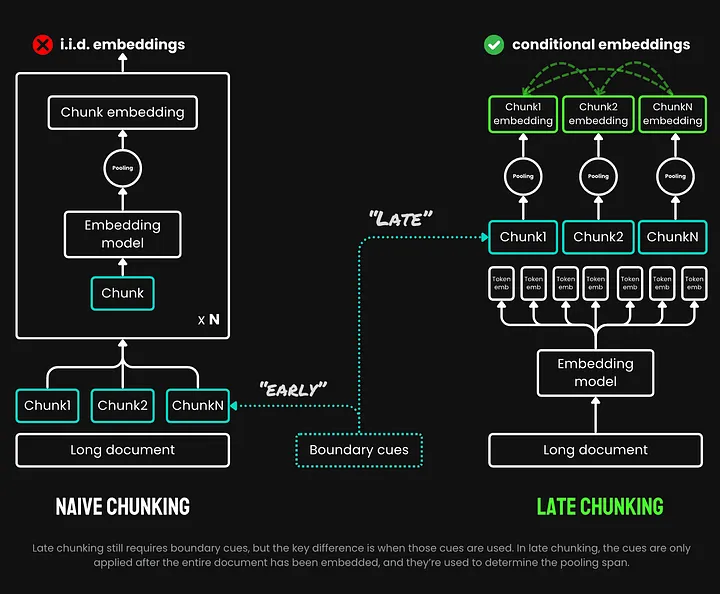


* **2. Contextual Retrieval**
  * **This method in short, involves embedding chunks with added context or METADATA.**
  * The concept invented by Anthropic, is where an LLM adds context to each chunk.
  * **The general concept is that you would have a single index for contextual vectors and a BM25 keyword index.**
  * Diagram of Anthropic's approach:

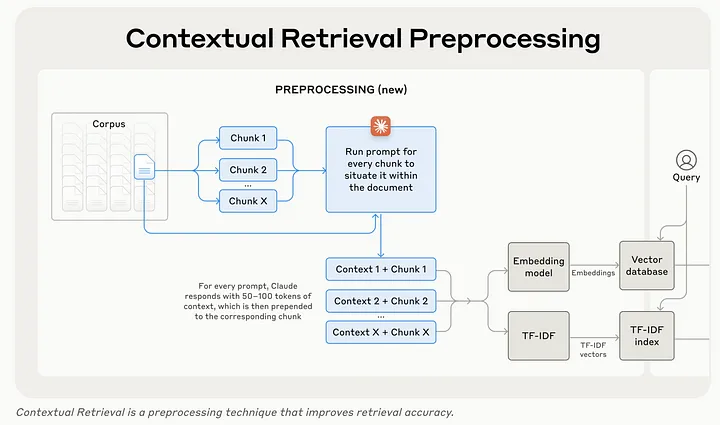

Source: [Late Chunking vs Contextual Retrieval: The Math Behind RAG’s Context Problem](https://medium.com/kx-systems/late-chunking-vs-contextual-retrieval-the-math-behind-rags-context-problem-d5a26b9bbd38)

# How do you Evaluate Chunking Strategies for Retrieval?
* ChromaDB the vector database company released a study on this using the OpenAI `text-embedding-3-large` model.
* Their main findings:
  1. The **Cluster Semantic Chunker** with a 200 token chunk size achieves the highest precision, precision with perfect recall, and intersection over union.
  2. The **LLM Chunker** achieves the highest recall.
  3. The **Recursive Character Text Splitter** with chunk size 200 achieves consistently high metrics and is a good lightweight option.
* The original paper by ChromaDB released in July 2024 entitled "Evaluating Chunking Strategies for Retrieval" can be found [here](https://research.trychroma.com/evaluating-chunking)
* The table below shows their findings.

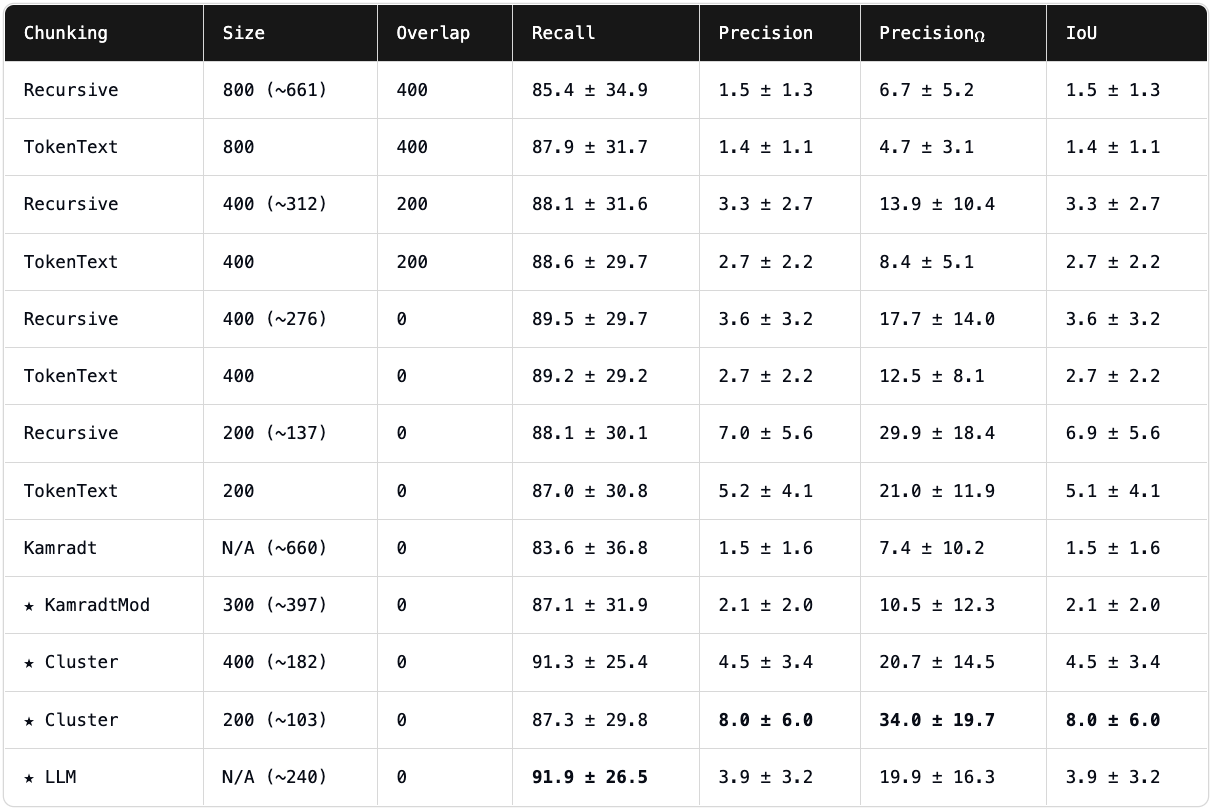

## Noteable Takeaways from their paper:
1. Embedding benchmarks such as the MTEB usuallly evaluate information retrieval performance on ENTIRE DOCUMENTS rather than at the token level.

2. Benchmarks for information retrieval also focus on "relative ranking" of retrieved documents.
  * LLMs are relatively insensitive to position of relevant information within a context window.

3. Information to a user's query may be spread across MULTIPLE DOCUMENTS, thus relative rankings are irrelevant.

4. Most developers DO NOT focus on 2 important factors when chunking:
  * a. Chunking strategy
  * b. Embedding model(s) used


5. **The chunking and embedding strategies that you choose WILL SIGNIFICANTLY EFFECT THE RETRIEVAL component of your RAG pipeline.**
  * This means that the tokens, text, and documents retrieved may not be even close to a user's query!
  * Thus the generated response will suffer if the documents retrieved are irrelevant!

6. **Chunking and Embedding strategies differ most often by DOMAIN and USECASE!**
  * Thus it is important to always examine this.

# Evaluating RAG Chunking Strategies - Implementation
* This is an implementation of the ChromaDB paper.

## Install Dependencies
* we begin by installing the code from the [ChromaDB Repo](https://github.com/brandonstarxel/chunking_evaluation/tree/main)

In [ ]:
%%capture
!pip install git+https://github.com/brandonstarxel/chunking_evaluation.git

## Import Dependencies

In [ ]:
from chunking_evaluation import GeneralEvaluation, SyntheticEvaluation, BaseChunker
from chromadb.utils import embedding_functions

## other imports
import os
import re
import requests
import pandas as pd
import numpy as np
from typing import List
from IPython.display import display, clear_output

## Custom Chunking Strategies
* Using the `BaseChunker` class we can define a custome chunker. This is the chunker:

```
class BaseChunker(ABC):
  @abstractmethod
  def split_text(self, text: str) -> List[str]:
    pass
```
* Only a `split_text` method can take in a string and return a list of strings which is the chunks.
  * This transformation can be iterated on.

* `SentenceChunker` below is a custom regex chunker used to split text at the sentence level.
  * 1 variable controls how many sentences are included in each chunk.

In [ ]:
## custom chunker for sentences
## `BaseChunker` class comes from the ChromaDB repository

class SentenceChunker(BaseChunker):
  def __init__(self, sentences_per_chunk: int =3):
    ## init chunker with number of sentences per chunk
    self.sentences_per_chunk = sentences_per_chunk

  def split_text(self, text: str) -> List[str]:
    ## handle cases where input text is empty
    if not text:
      return []

    ## split input text into sentences using regex
    sentences = re.split(r'(?<=[.!?])\s+', text)
    chunks = []

    ## group sentences into chunks based on specified number
    for i in range(0, len(sentences), self.sentences_per_chunk):
      ## combine sentences into single chunk
      chunk = ' '.join(sentences[i:i + self.sentences_per_chunk])
      chunks.append(chunk)

    ## return list of chunks
    return chunks

## Loading an Example Document
* Loading the NVIDIA Form 10-K for FY-24
* This document has 96 pages and is found at this [site](https://www.sec.gov/Archives/edgar/data/1045810/000104581024000029/nvda-20240128.htm)

In [ ]:
## load doc from github
doc = requests.get('https://raw.githubusercontent.com/ALucek/custom-rag-evals/refs/heads/main/domain_specific/nvidia_10k.txt')

## get content as string
with open("nvidia_10k.txt","w",encoding="utf-8") as f:
  ## write context to file
  f.write(doc.text)
# open file for reading
with open("nvidia_10k.txt","r",encoding="utf-8") as f:
  nvidia_10k = f.read()

In [ ]:
len(nvidia_10k)

366188

## Chunking Example Document

In [ ]:
## init custom SentenceChunker
sent_chunker = SentenceChunker(sentences_per_chunk = 10)

## split document
sent_chunks = sent_chunker.split_text(nvidia_10k)

In [ ]:
## len of chunks
len(sent_chunks)

175

Summary
* We split the doc into 175 chunks.
* This will be our test corpus for chunking metrics and evaluation.

## Count Tokens per chunk
* Lets see the average tokens per chunk

In [ ]:
%%capture
!pip install tiktoken==0.4.0

In [ ]:
import tiktoken
import numpy as np

## function to count number of tokens per chunk
def num_tokens_from_string(string: str, encoding_name: str) -> int:
  """Returns the number of tokens in a text string."""
  ##1. encode tokens
  encoding = tiktoken.get_encoding(encoding_name)
  ## 2. count tokens
  num_tokens = len(encoding.encode(string))

  return num_tokens

In [ ]:
## apply function to `sent_chunks`
token_counts = [num_tokens_from_string(chunk, "cl100k_base") for chunk in sent_chunks]

# calculate tokens
total_tokens = sum(token_counts)  # Calculate total tokens using 'sum'
average_tokens = total_tokens / len(sent_chunks)  # Average using 'len(sent_chunks)'
max_tokens = max(token_counts)  # Get maximum token count
min_tokens = min(token_counts)  # Get minimum token count
std_tokens = round(np.std(token_counts),2)


## print results
print(f"Average tokens per chunk: {average_tokens}")
print(f"Maximum tokens per chunk: {max_tokens}")
print(f"Minimum tokens per chunk: {min_tokens}")
print(f"Standard deviation tokens per chunk {std_tokens}")

Average tokens per chunk: 428.08
Maximum tokens per chunk: 2775
Minimum tokens per chunk: 149
Standard deviation tokens per chunk 280.26


Summary
* As we can see the average number of tokens per chunk is around 428 with the largest chunk being 2,775 and the smallest at 149.

In [ ]:
## view 1 index of chunks
sent_chunks[10]

'Headquartered in Santa Clara, California, NVIDIA was incorporated in California in April 1993 and reincorporated in Delaware in April 1998. Our Businesses\nWe report our business results in two segments. The Compute & Networking segment is comprised of our Data Center accelerated computing platforms and end-to-end networking platforms including Quantumfor InfiniBand and Spectrum for Ethernet; our NVIDIA DRIVE automated-driving platform and automotive development agreements; Jetson robotics and other\nembedded platforms; NVIDIA AI Enterprise and other software; and DGX Cloud software and services. The Graphics segment includes GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure; Quadro/NVIDIARTX GPUs for enterprise workstation graphics; virtual GPU, or vGPU, software for cloud-based visual and virtual computing; automotive platforms for\ninfotainment systems; and Omniverse Enterprise software for building and operating metaverse and 3D int

# Metrics for RAG Chunk Evaluation
* **The MOST IMPORTANT takeaway from the metric evaluation here is that we are using a TOKEN LEVEL evaluation**
  * This is much different than standard information retrieval metrics which focus on the document level.
  * Token level evaluation aligns more closely with LLMs and how they process information.

* The built in metrics created by ChromaDB are slightly different from "classic" information retrieval metrics, which usually function on a **document level**.
  * These metrics are more concerned with measuring the **token level performance** of our chunking and embedding strategies.
  * The motivation for this:
    
    1. For a given query to a corpus, **ONLY a SUBSET of tokens within that corpus will be relevant**.

    2. Ideally, for both efficiency and accuracy, the retrieval system should retrieve **EXACTLY and ONLY the RELEVANT tokens** for each query across the entire corpus.

    3. This is more efficent for testing chunking strategies as a retrieval part of RAG systems, as we are **less concerned with the specific document** than the **actual relevant token level information** for the LLM to process.
    
    4. This will try to **maximize the relevant tokens** and exclude:
      * irrelevant
      * redundant/duplicate and
      * distracting superfluous information

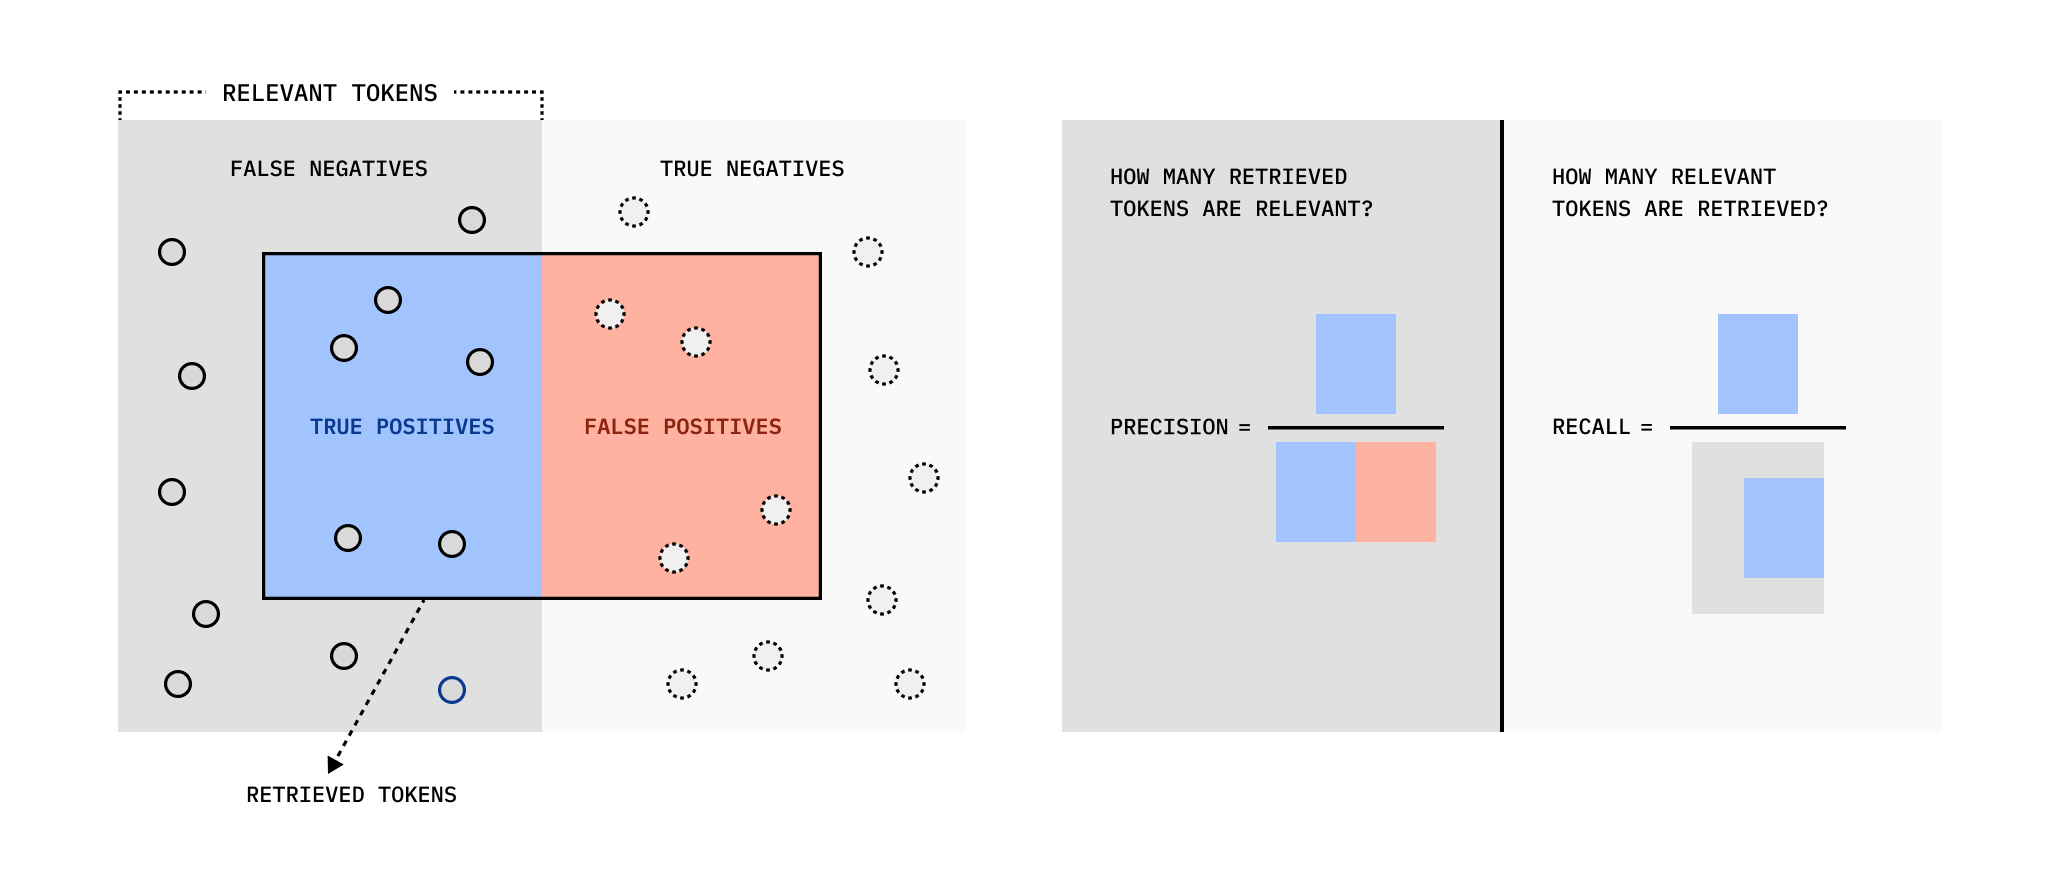

Source: [Evaluating Chunking Strategies for Retrieval](https://research.trychroma.com/evaluating-chunking)
* Original ChromaDB paper

## Variables
* 𝑞 -> specific query
* 𝐂 -> chunked corpus (entire document split into chunks)
* 𝑡ₑ -> set of tokens in relevant excerpts/highlights (ground truth)
* 𝑡ᵣ -> set of tokens in retrieved chunks (what our system returns)

* A **highlight** is a segment of text in the original document that contains the **relevant information** needed to answer a specific query.
  * Highlights represent the **"ground truth"** against which we measure our chunking and retrieval performance.

* As an example:

  * **Document:** *"The Sun is composed primarily of hydrogen and helium. Through nuclear fusion in its core, it converts hydrogen into helium, releasing massive amounts of energy. This energy travels to Earth as sunlight and heat."

  * **Query:** "How does the Sun produce energy?"

  * **Highlight:** "Through nuclear fusion in its core, it converts hydrogen into helium, releasing massive amounts of energy."

## Recall
* Equation: 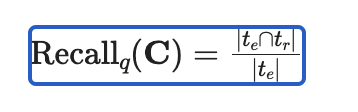



* **Calculated by:**
  * length of overlap between retrieved chunks and highlights / total length of highlights

  * Measures what fraction of the important/relevant text is captured by the retrieved chunks.
  * Ranges from 0 to 1
    * 1 means all relevant text was captured.
    * A low recall means the chunking strategy is missing important information.

* **Answers:**
  * How much of these important highlighted segments did we capture?

* **Example:**
  * If a highlight is 100 tokens and our chunks only capture 70 tokens of it, recall = 0.7

## Precision

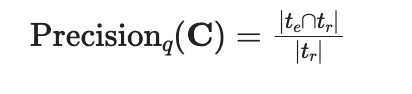

* **Calculated by:**
  * length of overlap between retrieved chunks and highlights / total length of retrieved chunks

* Measures how much of the retrieved text is actually relevant.
* Ranges from 0 to 1, where 1 means all retrieved text was relevant.
* A low precision means the chunks contain a lot of irrelevant text.

* **Answers:**
  * How much of what we retrieved matches these highlights?

* **Example:** If we retrieve 200 tokens of text but only 70 overlap with highlights, precision = 0.35

## Precision Ω

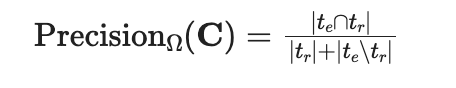

* This measures precision in an "ideal scenario" where **all relevant text is captured.**
* Shows the theoretical best precision possible for a given chunking strategy.

  * This is similar to regular precision but assumes you've retrieved **all highlights.**
  * Lower precision omega means chunks are inherently too large or poorly aligned with natural text boundaries.

* **Answers:**
  * If we made sure to get all the highlights, how precise could we be?

* **Example:**
  * If a chunking strategy always creates chunks twice as large as needed, precision omega would be around 0.5

## Intersection over Union (IoU)

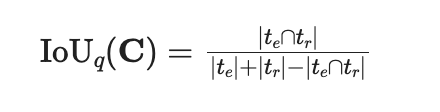


* **Calculated by:**
  * length of overlap / length of union of retrieved chunks and highlights

  * Balances both precision and recall in a single metric.
  * Ranges from 0 to 1 --> 1 is perfect overlap.
  * A low IoU indicates:
    * either missing content (poor recall) or
    * retrieving too much irrelevant text (poor precision).
  * IoU penalizes missing important content and including irrelevant content while handling redundant information.

* **Answers:**
  * How well do our retrieved chunks overlap with these highlights overall?

* **Example:**
  * If we retrieve 200 tokens, the highlight is 100 tokens, and overlap is 70 tokens,
  * `IoU = 70/(200+100-70) = 0.304`

# Metric Interpretation

These metrics work well together:

* High recall + low precision = retrieving too much text

* Low recall + high precision = missing important content

* High IoU = good balance of both

* Precision Ω helps evaluate the chunking strategy independent of the retrieval step


# Evaluating Chunking Strategies and Embedding Models
* Built into the ChromaDB repo is a default evaluation structure of 5 text documents and respective question & highlights data. * The text corpus includes a mix of clean and unstructured text documents to simulate various text chunking and retrieval scenarios. These include:

1. **State of the Union 2024:** A clean, well-structured transcript of the 2024 presidential address (10,444 tokens)

2. **Wikitext:** A curated collection of high-quality Wikipedia articles from verified Good and Featured sections (26,649 tokens subset)

3. **UltraChat 200k:** A dataset of ChatGPT-generated dialogues with JSON syntax intact to simulate real-world messy data (7,727 tokens subset)

4. **ConvFinQA:** A conversational Q&A dataset focused on numerical reasoning in financial reports (166,177 tokens subset)

5. **PMC Open Access:** Biomedical and life sciences journal literature from the National Library of Medicine's open access collection (117,211 tokens subset)


A standard set of question and highlights have been generated and filtered as well, full file viewable in the original repo.

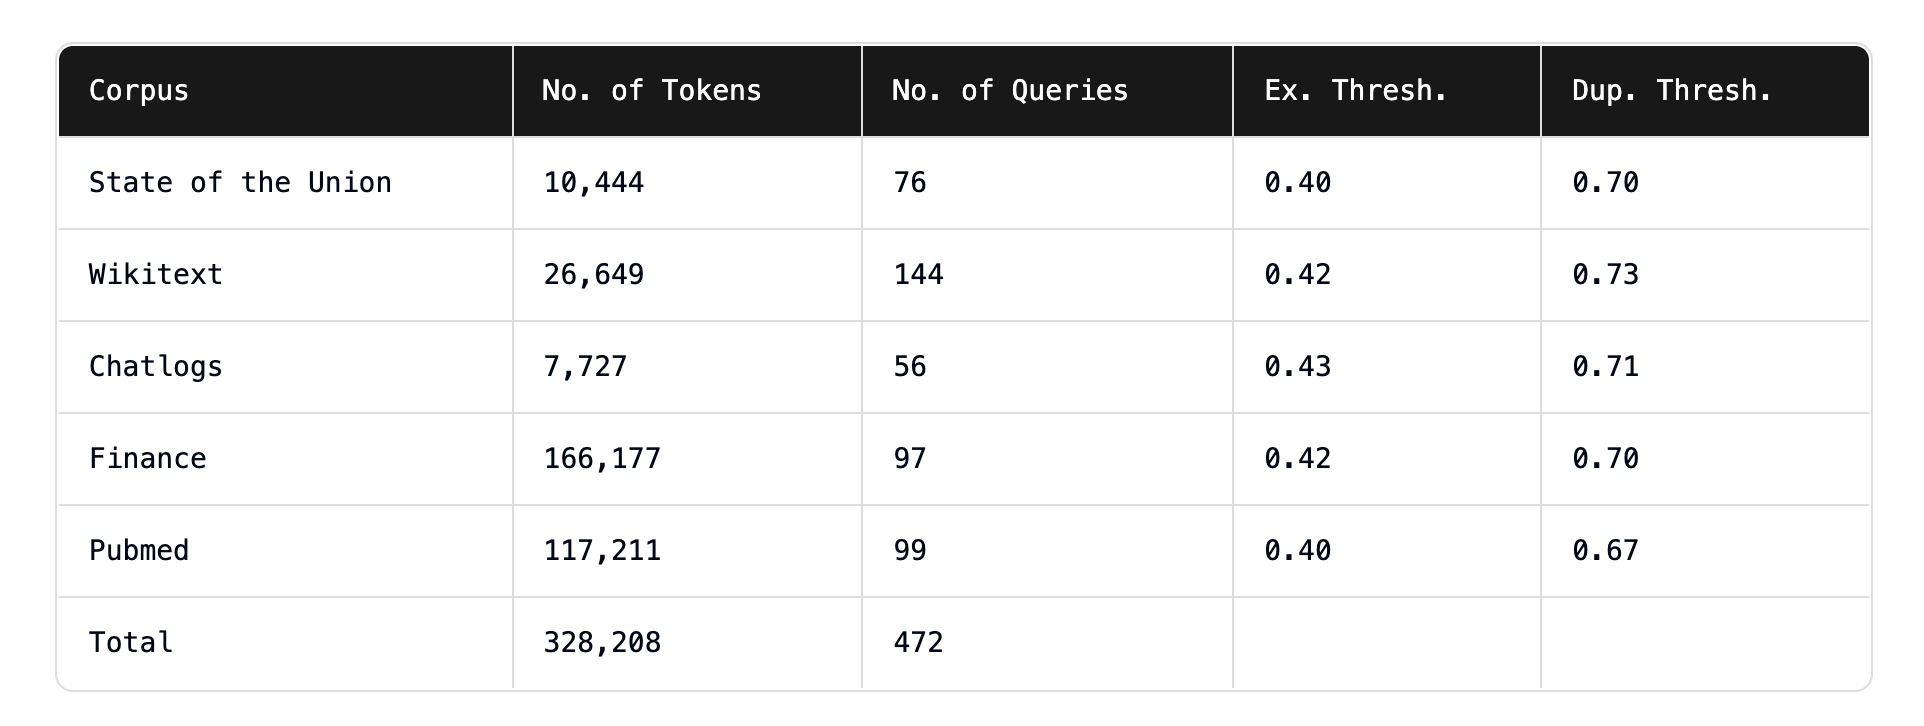

The question/references take the form of, for example:

* **Question:** *What were the values of other indefinite-lived intangible assets at the end of 2011 and 2012?*

* **Reference(s):** `[{"content": "other indefinite-lived intangible assets were $132 million and $174 million at december 31, 2012 and 2011, respectively, and principally included registered trademarks","start_index": 568963,"end_index": 569130}]`


Which show the respective text chunk, and its character position within the entire database collection.

# General Evaluation Process
* The general evaluation will take the text, chunk it using the chosen chunker along with the chunks start and end index, then:

* **Calculate Retrieval Performance:**
  
  1. Embed the evaluation questions using the chosen embedding function

  2. Perform vector similarity search to retrieve `top-k` most relevant chunks per question

  3. Calculates standard retrieval metrics:

    a. **Recall:** How much of the highlighted segments were captured

    b. **Precision:** How much of the retrieved chunks were actually relevant

    c. **IoU:** Overall balance of precision and recall

* **Calculate Precision Ω Performance:**

1. Examine **ALL chunks** in the collection

2. Identify which chunks contain any part of the highlight segments

3. Calculate theoretical best precision possible if you retrieved all necessary chunks


# Chunk General Evaluation Implementation
* This is the ChromaDB method

In [ ]:
## set OPENAI API KEY
from getpass import getpass

OPENAI_API_KEY = getpass("Enter your Open AI API Key: ")

Enter your Open AI API Key: ··········


In [ ]:
## set open ai env
import os

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
## init General Eval function
evaluation = GeneralEvaluation()

## define chunking approach
sentence_chunker = SentenceChunker(sentences_per_chunk = 10)

## Define OpenAI Embedding Model
default_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=OPENAI_API_KEY,
    model_name="text-embedding-3-large",
)
# Run Eval with Chunker and Embedding Model
results = evaluation.run(sentence_chunker, default_ef)

## Get Results

In [ ]:
## define helper function
def print_metrics(results):
  """Function to print chunk metrics"""
  ## summary metrics dict
  metrics = {
      'Recall': (results['recall_mean'], results['recall_std']),
      'Precision': (results['precision_mean'], results['precision_std']),
      'Precision Ω': (results['precision_omega_mean'], results['precision_omega_std']),
      'IoU': (results['iou_mean'], results['iou_std']),

  }

  ## print each metric with mean +/- std
  for metric, (mean, std) in metrics.items():
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

In [ ]:
## print metrics
print_metrics(results)

Recall: 0.8724 ± 0.3192
Precision: 0.0371 ± 0.0303
Precision Ω: 0.1674 ± 0.1084
IoU: 0.0370 ± 0.0303


### Observations
* Chunking by 10 sentences shows HIGH recall at 87.45% ± 31.67%.
  * What this means is that this is an effective retrieval of relevant information.
* Precision is LOW at 3.71% ± 3.03% and IoU is also low at 3.7% ± 3.03%.
  * This means that we have a SIGNIFICANT AMOUNT OF IRRELEVANT TEXT IN OUR CHUNKS.

* **Precision Ω value of 16.74% ± 10.84% indicates that even with optimal retrieval conditions, the chunking strategy includes SIGNIFICANT EXTRANEOUS CONTENT.**

* Compared to the benchmark chunkers we saw above:
  * Recall aligned with the "state of the art" approaches which ranged from 83-91%.
  * **Precision for our retrieval above immediately tells us that we have room for improvement in our chunking strategy such as:**
    * 1. reduce chunk size
    * 2. change chunk boundaries
    * 3. change chunking method

# Embedding Function Evaluation
* Besides focusing on chunking methods, we can also focus on different embedding strategies.
* Is it the chunking strategy or the embeddings that we need to change, or both?

## ChromaDB existing integrations
* We can use the built-in embedding functions from Chroma's repository such as the OpenAI embeddings. '
* However, we can also leverage open source embedding models such as SentenceTransformers.

In [ ]:
## load open source embedding model
st_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-MiniLM-L6-v2",
)

## use same chunking method as above -- sentence level
sentence_chunker = SentenceChunker(sentences_per_chunk= 10)

## run Eval with Chunker and Ollama embedding function
st_results = evaluation.run(sentence_chunker, st_ef)

## Get results
print_metrics(st_results)

Recall: 0.7859 ± 0.3897
Precision: 0.0336 ± 0.0306
Precision Ω: 0.1674 ± 0.1084
IoU: 0.0335 ± 0.0306


## Summary
* We can see the Recall was not as high as our previosu experiment, while both Precision values and IoU remained about the same.
* This was expected since the `all-MiniLM-L6-v2` has a dimension of 384 and max sequence length of 512 so for larger chunks it will not be able to encode the same amount of information as a larger embedding model such as the open ai model.

## Custom Embedding Function
* ChromaDB has a custom embedding function just as we had a custom chunking function above.

```
from chromadb import Documents, EmbeddingFunction, Embeddings

class MyEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        # embed the documents somehow
        return embeddings
```

# Multiple Evaluations at the same time!
* This is perhaps the most important part of this notebook.
* When trying to find the optimal chunk and embeddings configuration for your application, data, and use cases, you will want to run hyperparameter testing as with most machine learning uses cases.
* We can do this using the ChromaDB setup below.

## Define Chunkers and Embedding Models
* You don't have to use only 1 chunker here, you can use multiple chunkers and configs.
* You could run a "competition" between multiple chunking techniques such as:
  * Recursive chunker
  * Semantic chunker
  * ..etc..

In [ ]:
## 1. define chunking configs
chunkers = [
    SentenceChunker(sentences_per_chunk = 5),
    SentenceChunker(sentences_per_chunk = 10),
    SentenceChunker(sentences_per_chunk = 15),
    SentenceChunker(sentences_per_chunk = 20),
    SentenceChunker(sentences_per_chunk = 25),

]

## 2. Define embedding configs
embedders = [
    embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2"),
    embedding_functions.SentenceTransformerEmbeddingFunction(model_name="Snowflake/snowflake-arctic-embed-m-v1.5"),
    embedding_functions.OpenAIEmbeddingFunction(api_key=OPENAI_API_KEY, model_name="text-embedding-3-large"),

]

## Main "Sweep"
* This is the logic we need to test all chunkers and all embeddings in multiple combinations.
* We will then store the results in a dataframe.


In [ ]:
import torch

## setup device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def move_tensors_to_device(obj, device):
    if isinstance(obj, dict):
        return {k: move_tensors_to_device(v, device) for k, v in obj.items()}
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return obj

In [ ]:
# Initialize Evaluation and Results Storage
evaluation = GeneralEvaluation()
results = []

# Helper Function
def get_config_name(chunker, ef):
    chunk_size = chunker.sentences_per_chunk if hasattr(chunker, 'sentences_per_chunk') else 0
    ef_name = ef.model_name if hasattr(ef, 'model_name') else ef.__class__.__name__
    return f"{chunker.__class__.__name__}_{chunk_size}_{ef_name}"

# Progress tracking
total_combinations = len(chunkers) * len(embedders)
current_combination = 0

# Run evaluation sweep
for chunker in chunkers:
    for ef in embedders:
        current_combination += 1
        try:
            print(f"Evaluating combination {current_combination}/{total_combinations}:")
            print(f"  Chunker: {chunker.__class__.__name__} (size: {chunker.sentences_per_chunk})")
            print(f"  Embedding: {ef.model_name if hasattr(ef, 'model_name') else ef.__class__.__name__}")

            # Run evaluation
            result = evaluation.run(chunker, ef, retrieve=5)
            result = move_tensors_to_device(result, device) ## move to GPU

            # Clean up and store results
            if 'corpora_scores' in result:
                del result['corpora_scores']

            # Add configuration identifiers
            result['chunker'] = chunker.__class__.__name__
            result['chunk_size'] = chunker.sentences_per_chunk
            result['embedding_function'] = ef.model_name if hasattr(ef, 'model_name') else ef.__class__.__name__
            result['config'] = get_config_name(chunker, ef)

            results.append(result)
            clear_output(wait=True)

        except Exception as e:
            # Error Handling Just in Case
            print(f"Error in combination {current_combination}: {str(e)}")
            continue

# Create final DataFrame and display
df = pd.DataFrame(results)
print("\nFinal Results:")
display(df)

,iou_mean,iou_std,recall_mean,recall_std,precision_omega_mean,precision_omega_std,precision_mean,precision_std,chunker,chunk_size,embedding_function,config
0,0.060698,0.055117,0.751719,0.404472,0.294542,0.176066,0.061196,0.055480,SentenceChunker,5,SentenceTransformerEmbeddingFunction,SentenceChunker_5_SentenceTransformerEmbedding...
1,0.068533,0.054363,0.855439,0.324309,0.294542,0.176066,0.068952,0.054738,SentenceChunker,5,OpenAIEmbeddingFunction,SentenceChunker_5_OpenAIEmbeddingFunction
2,0.033468,0.030560,0.785924,0.389651,0.167426,0.108418,0.033556,0.030633,SentenceChunker,10,SentenceTransformerEmbeddingFunction,SentenceChunker_10_SentenceTransformerEmbeddin...
3,0.037013,0.030270,0.872402,0.319169,0.167426,0.108418,0.037063,0.030316,SentenceChunker,10,OpenAIEmbeddingFunction,SentenceChunker_10_OpenAIEmbeddingFunction
4,0.021537,0.019467,0.766879,0.403846,0.120034,0.082415,0.021576,0.019500,SentenceChunker,15,SentenceTransformerEmbeddingFunction,SentenceChunker_15_SentenceTransformerEmbeddin...
5,0.025017,0.020563,0.884177,0.311462,0.120034,0.082415,0.025030,0.020576,SentenceChunker,15,OpenAIEmbeddingFunction,SentenceChunker_15_OpenAIEmbeddingFunction
6,0.015770,0.015197,0.738888,0.428088,0.093078,0.063231,0.015783,0.015202,SentenceChunker,20,SentenceTransformerEmbeddingFunction,SentenceChunker_20_SentenceTransformerEmbeddin...
7,0.018828,0.015445,0.867072,0.329053,0.093078,0.063231,0.018836,0.015449,SentenceChunker,20,OpenAIEmbeddingFunction,SentenceChunker_20_OpenAIEmbeddingFunction
8,0.011408,0.012276,0.663522,0.462785,0.075714,0.049766,0.011417,0.012281,SentenceChunker,25,SentenceTransformerEmbeddingFunction,SentenceChunker_25_SentenceTransformerEmbeddin...
9,0.015147,0.012667,0.862016,0.339629,0.075714,0.049766,0.015149,0.012668,SentenceChunker,25,OpenAIEmbeddingFunction,SentenceChunker_25_OpenAIEmbeddingFunction


## Plot Recall by Chunk Size

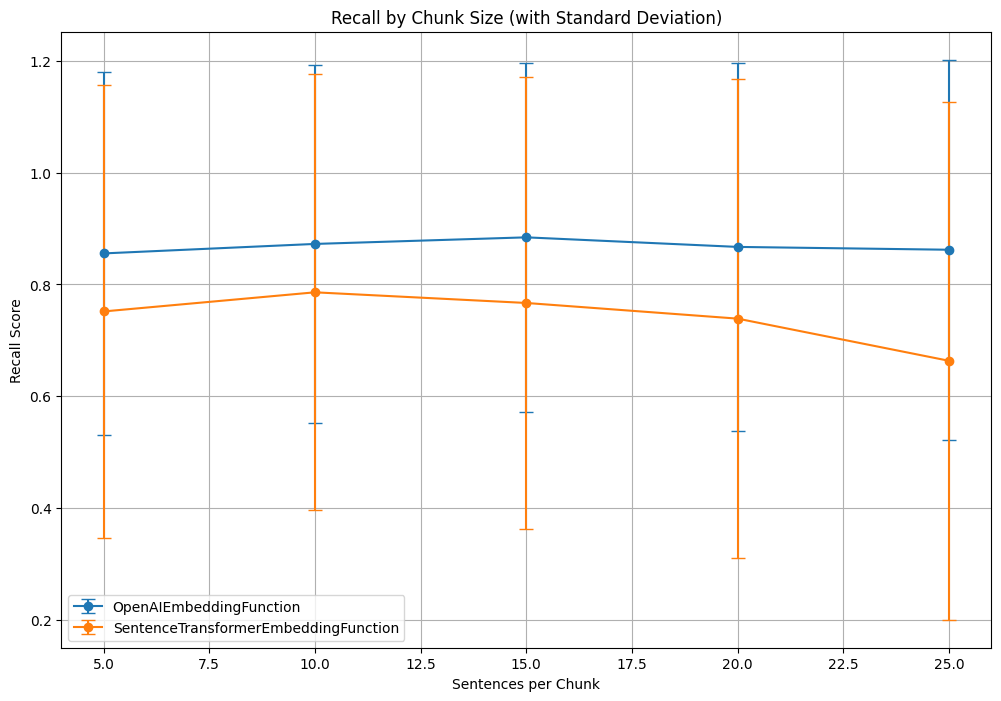

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Group data by embedding function
embedding_groups = df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['recall_mean'],
                 yerr=group['recall_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("Recall Score")
plt.title("Recall by Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();


Summary
* Recall measures what fraction of the important/relevant text is captured by the retrieved chunks.
* A value of 1 means all the relevant text was captured in the chunk.
* We can see that the Open AI embedding models stay pretty consistent with all chunks as the chunk sizes increase whereas the SentenceTransformer models do not.

## Plot Precision by Chunk Size

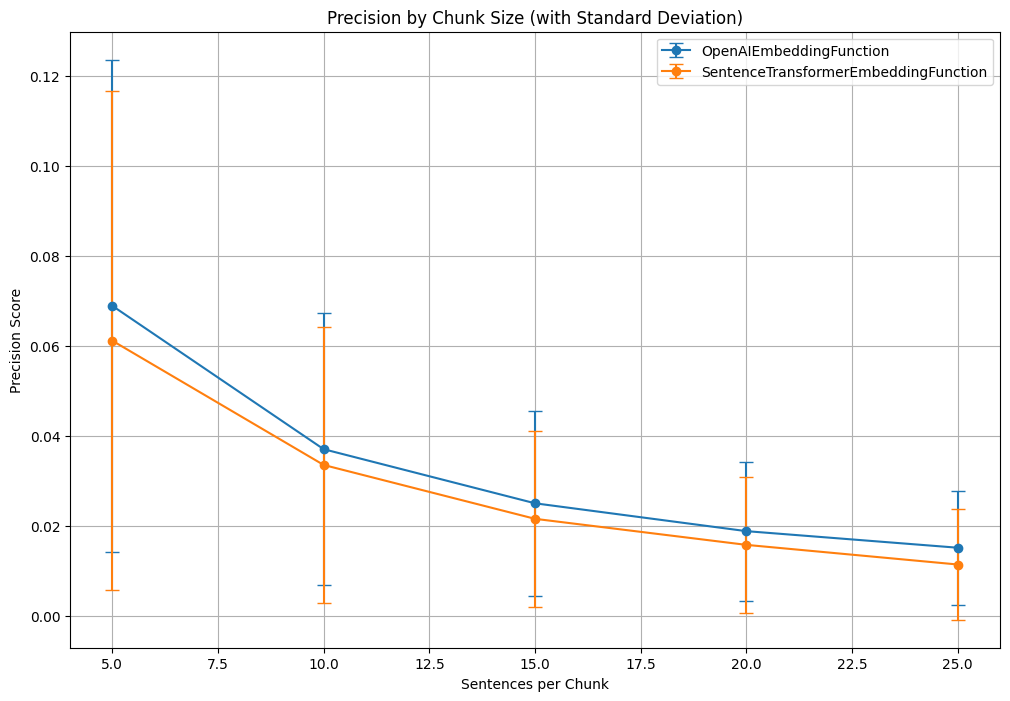

In [31]:
# Group data by embedding function
embedding_groups = df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['precision_mean'],
                 yerr=group['precision_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("Precision Score")
plt.title("Precision by Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();


Summary
* The precision is decreasing with both embedding model groups as the chunks get bigger.
* So as the chunk sizes get bigger the relevant text retrieved is LESS RELEVANT.

## Plot IoU by Chunk Size

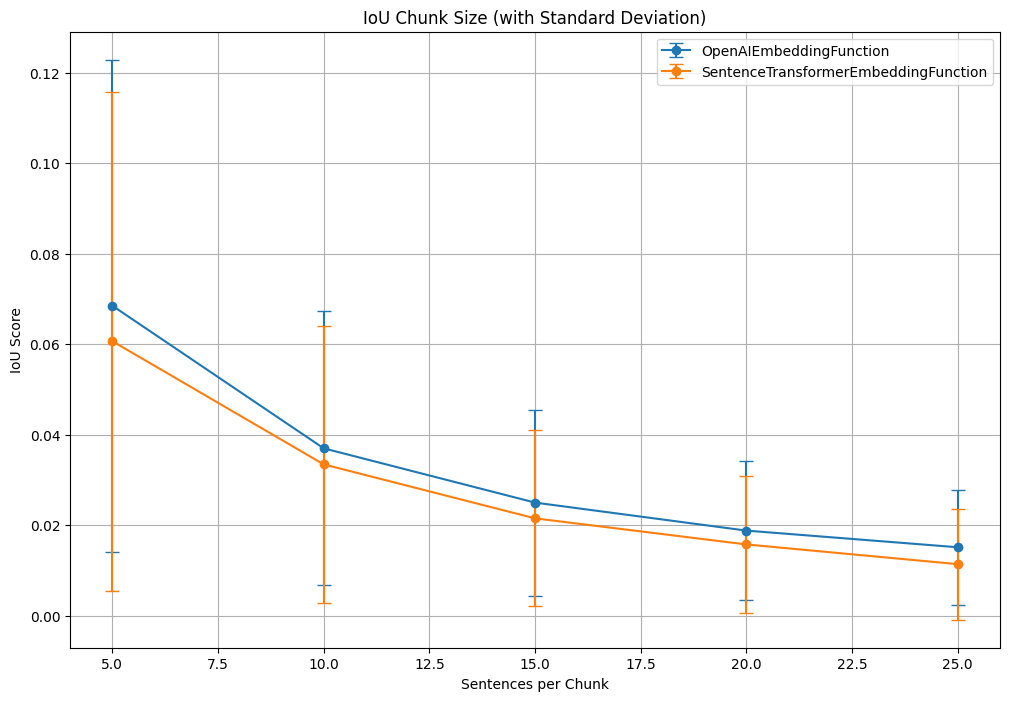

In [34]:
# Group data by embedding function
embedding_groups = df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['iou_mean'],
                 yerr=group['iou_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("IoU Score")
plt.title("IoU Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();


Summmary
* IoU measures length of overlap / length of union of retrieved chunks and highlights
* It Balances both precision and recall in a single metric.
  * Values Range from 0 to 1 --> 1 is perfect overlap.

* A low IoU indicates:
  * either missing content (poor recall) or
retrieving too much irrelevant text (poor precision).
* We can see that as with precision as the chunks get bigger we are retrieving too much irrelevant information.

## Plot Precision Omega by Chunk Size

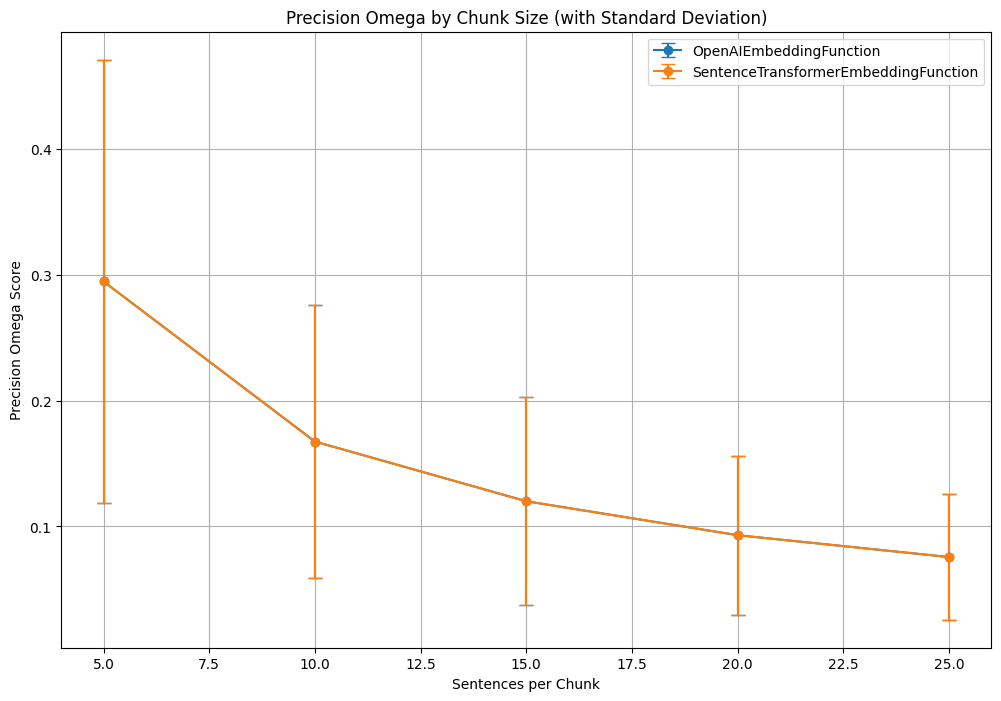

In [35]:
# Group data by embedding function
embedding_groups = df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['precision_omega_mean'],
                 yerr=group['precision_omega_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("Precision Omega Score")
plt.title("Precision Omega by Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();


Summary
* Precision Omega measures precision in an "ideal scenario" where all relevant text is captured.
* This metric shows the theoretical best precision possible for a given chunking strategy.
* This is similar to regular precision but assumes you've retrieved all highlights.
* Lower precision omega means chunks are inherently too large or poorly aligned with natural text boundaries.
* The trend we see here is that the larger the chunks the poorer the boundaries are and again this verifies that our chunks are too big for our embedding models and LLM.

# Domain Specific Evaluation Pipelines
* General evaluations are great for getting started, it's more than likely that you're looking for the best chunking strategy and embedding model combination for your own specific documentation and domain (e.g. law, medicine, finance).

* ChromaDB also open sourced their methodology for generating a dataset of questions and chunks from a text corpus automatically in their `synthetic_evaluation` framework, allowing you to generate evaluation datasets tailored to your domain.

* The pipeline works by:

1. Randomly selecting segments (4000 characters) from your input documents

2. Using GPT-4 to generate natural questions based on the content, along with relevant supporting references

3. Identifying and extracting precise text spans that contain the information needed to answer each question

4. Filter for duplicates and similarity to remove redundant or unrelated questions.

Within the pipeline there are 2 reference extraction methods available:

1. **Exact matching**
  * Finds precise text spans in the source document

2. **Approximate matching**
  * Pre-chunks text into 100-character segments and allows references to span multiple chunks


We can apply this technique with the NVIDIA Form 10-K document.

In [41]:
# Specify the corpora paths, you can have multiple but we'll just use our one file
corpora_paths = [
    '/content/nvidia_10k.txt',
]
csv_path = '/content/generated_queries_and_excerpts.csv'

# Initialize the evaluation
synthetic_pipeline = SyntheticEvaluation(corpora_paths, csv_path, openai_api_key=OPENAI_API_KEY)

## Run Data Generation Pipeline

The generate_queries_and_excerpts method takes the arguments:

1. **approximate_excerpts**
  * Whether or not to use the chunked flexible approach or exact text matching

2. **num_rounds**
  * How many times per document to run query generations

3. **queries_per_corpus**
  * Number of queries to generate per round, -1 will run indefinitely.

In [42]:
synthetic_pipeline.generate_queries_and_excerpts(approximate_excerpts=True,
                                         num_rounds=1,
                                         queries_per_corpus=5)

Trying Query 0
Trying Query 1
Trying Query 2
Error occurred: Unterminated string starting at: line 34 column 18 (char 2384)
Trying Query 2
Trying Query 3
Trying Query 4


In [43]:
## view some of the synthetic queries
synthetic_df = pd.read_csv(csv_path)
synthetic_df.head()

,question,references,corpus_id
0,What are the critical areas of accounting esti...,"[{""content"": ""condition or results of operatio...",/content/nvidia_10k.txt
1,How do stock options vest under the stock plan...,"[{""content"": "" subject to continued service, w...",/content/nvidia_10k.txt
2,How is compensation expense recognized for dif...,"[{""content"": ""conditions, or market-based PSUs...",/content/nvidia_10k.txt
3,What are some risks associated with the compan...,"[{""content"": ""and could damage our business.\n...",/content/nvidia_10k.txt
4,What are the values of marketable equity secur...,"[{""content"": ""equity securities totaled $225 m...",/content/nvidia_10k.txt


## Filter Poor Excerpts

* This method will filter out questions where any of the references aren't sufficiently similar to the question semantically.
* This is done by embedding the question and reference(s) and comparing both through semantic similarity.
* Under a certain threshold, defaulting to 0.36 the line is removed.

In [44]:
synthetic_pipeline.filter_poor_excerpts(threshold=0.36)

Corpus: /content/nvidia_10k.txt - Removed 1 .


## Remove Duplicates

* This method will then examine the questions generated.
  * first it removes all of the **exact duplicates**
  * then creates a similarity matrix comparing every question to every other, again by embedding.

* Then it applies a greedy algorithm to remove similar questions by:

1. Keeping the first question

2. Removing any later questions that are too similar above a certain threshold. 0.78 by default.

3. Move to the next question and repeat

In [45]:
synthetic_pipeline.filter_duplicates(threshold=0.7)

Corpus: /content/nvidia_10k.txt - Removed 0 .


Summary
* We now have a cleaned dataset of relevant and unique questions as our synthetic evaluation dataset. We initially generated 105, but reduced down to 66 through our filters.

In [46]:
synthetic_df = pd.read_csv(csv_path)
synthetic_df.tail()

,question,references,corpus_id
0,What are the critical areas of accounting esti...,"[{""content"": ""condition or results of operatio...",/content/nvidia_10k.txt
1,How do stock options vest under the stock plan...,"[{""content"": "" subject to continued service, w...",/content/nvidia_10k.txt
2,How is compensation expense recognized for dif...,"[{""content"": ""conditions, or market-based PSUs...",/content/nvidia_10k.txt
3,What are the values of marketable equity secur...,"[{""content"": ""equity securities totaled $225 m...",/content/nvidia_10k.txt


# Running more Evaluations -- this time on synthetic data!
We can now employ the same techniques as earlier to run evaluations, this time however using our newly created dataset.

In [48]:
# Define Chunking Approach
sentence_chunker = SentenceChunker(sentences_per_chunk = 10)

# Define OpenAI Embedding Model
default_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=os.environ["OPENAI_API_KEY"],
    model_name="text-embedding-3-large"
)

# Run the Eval With Chunker and Embedding Model on our Synthetic Dataset
synth_results = synthetic_pipeline.run(sentence_chunker, default_ef)

# Display our Results
print_metrics(synth_results)

Recall: 0.9367 ± 0.1097
Precision: 0.0195 ± 0.0077
Precision Ω: 0.1184 ± 0.0480
IoU: 0.0195 ± 0.0077


Compared to our earlier results:
```
Recall: 0.8745 ± 0.3167
Precision: 0.0371 ± 0.0303
Precision Ω: 0.1674 ± 0.1084
IoU: 0.0370 ± 0.0303
```

We see a lower recall, but higher precision, precision Ω, and IoU!
Let's also perform the same sweep and observe the results:

In [50]:
# Defining our Configurations
chunkers = [
    SentenceChunker(sentences_per_chunk = 5),
    SentenceChunker(sentences_per_chunk = 10),
    SentenceChunker(sentences_per_chunk = 15),
    SentenceChunker(sentences_per_chunk = 20),
]

# Defining our Embedding Functions
embedders = [
    embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2"),
    embedding_functions.OpenAIEmbeddingFunction(api_key=os.environ["OPENAI_API_KEY"], model_name="text-embedding-3-large"),
]

# Initialize Results Storage
synth_results = []

# Helper Function
def get_config_name(chunker, ef):
    chunk_size = chunker.sentences_per_chunk if hasattr(chunker, 'sentences_per_chunk') else 0
    ef_name = ef.model_name if hasattr(ef, 'model_name') else ef.__class__.__name__
    return f"{chunker.__class__.__name__}_{chunk_size}_{ef_name}"

# Progress tracking
total_combinations = len(chunkers) * len(embedders)
current_combination = 0

# Run evaluation sweep
for chunker in chunkers:
    for ef in embedders:
        current_combination += 1
        try:
            print(f"Evaluating combination {current_combination}/{total_combinations}:")
            print(f"  Chunker: {chunker.__class__.__name__} (size: {chunker.sentences_per_chunk})")
            print(f"  Embedding: {ef.model_name if hasattr(ef, 'model_name') else ef.__class__.__name__}")


            # Run evaluation again on synthetic data
            result = evaluation.run(chunker, ef, retrieve=5)
            result = move_tensors_to_device(result, device) ## move to GPU


            # Clean up and store results
            if 'corpora_scores' in result:
                del result['corpora_scores']


            # Add configuration identifiers
            result['chunker'] = chunker.__class__.__name__
            result['chunk_size'] = chunker.sentences_per_chunk
            result['embedding_function'] = ef.model_name if hasattr(ef, 'model_name') else ef.__class__.__name__
            result['config'] = get_config_name(chunker, ef)

            synth_results.append(result)
            clear_output(wait=True)

        except Exception as e:
            # Error Handling Just in Case
            print(f"Error in combination {current_combination}: {str(e)}")
            continue

# Create final DataFrame and display
synth_df = pd.DataFrame(synth_results)
print("\nFinal Results:")
display(synth_df)


Final Results:


,iou_mean,iou_std,recall_mean,recall_std,precision_omega_mean,precision_omega_std,precision_mean,precision_std,chunker,chunk_size,embedding_function,config
0,0.060698,0.055117,0.751719,0.404472,0.294542,0.176066,0.061196,0.055480,SentenceChunker,5,SentenceTransformerEmbeddingFunction,SentenceChunker_5_SentenceTransformerEmbedding...
1,0.068741,0.054329,0.858443,0.321787,0.294542,0.176066,0.069153,0.054703,SentenceChunker,5,OpenAIEmbeddingFunction,SentenceChunker_5_OpenAIEmbeddingFunction
2,0.033469,0.030560,0.785924,0.389651,0.167426,0.108418,0.033556,0.030633,SentenceChunker,10,SentenceTransformerEmbeddingFunction,SentenceChunker_10_SentenceTransformerEmbeddin...
3,0.037015,0.030271,0.872402,0.319169,0.167426,0.108418,0.037066,0.030317,SentenceChunker,10,OpenAIEmbeddingFunction,SentenceChunker_10_OpenAIEmbeddingFunction
4,0.021537,0.019467,0.766879,0.403846,0.120034,0.082415,0.021576,0.019500,SentenceChunker,15,SentenceTransformerEmbeddingFunction,SentenceChunker_15_SentenceTransformerEmbeddin...
5,0.025013,0.020562,0.884177,0.311462,0.120034,0.082415,0.025026,0.020574,SentenceChunker,15,OpenAIEmbeddingFunction,SentenceChunker_15_OpenAIEmbeddingFunction
6,0.015773,0.015197,0.738888,0.428088,0.093078,0.063231,0.015786,0.015203,SentenceChunker,20,SentenceTransformerEmbeddingFunction,SentenceChunker_20_SentenceTransformerEmbeddin...
7,0.018760,0.015456,0.864954,0.331401,0.093078,0.063231,0.018768,0.015460,SentenceChunker,20,OpenAIEmbeddingFunction,SentenceChunker_20_OpenAIEmbeddingFunction


# Plot synthetic results and compare


## Plot Recall by Chunk Size - Synthetic Data

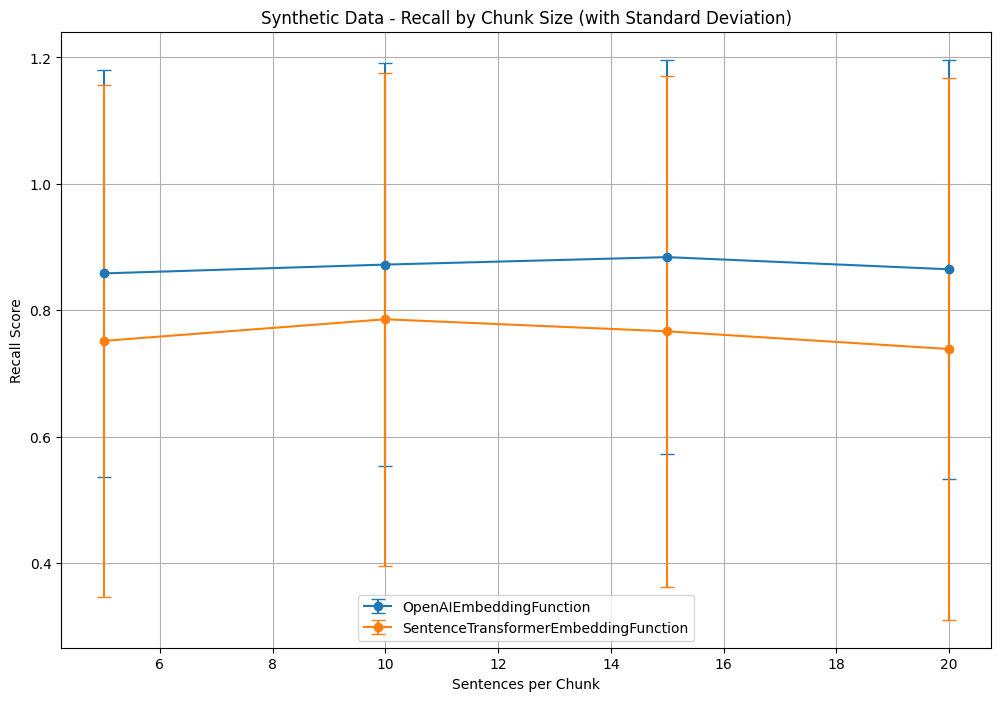

In [51]:
# Group data by embedding function
embedding_groups = synth_df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['recall_mean'],
                 yerr=group['recall_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("Recall Score")
plt.title("Synthetic Data - Recall by Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();


## Plot Precision by Chunk Size -- Synthetic Data

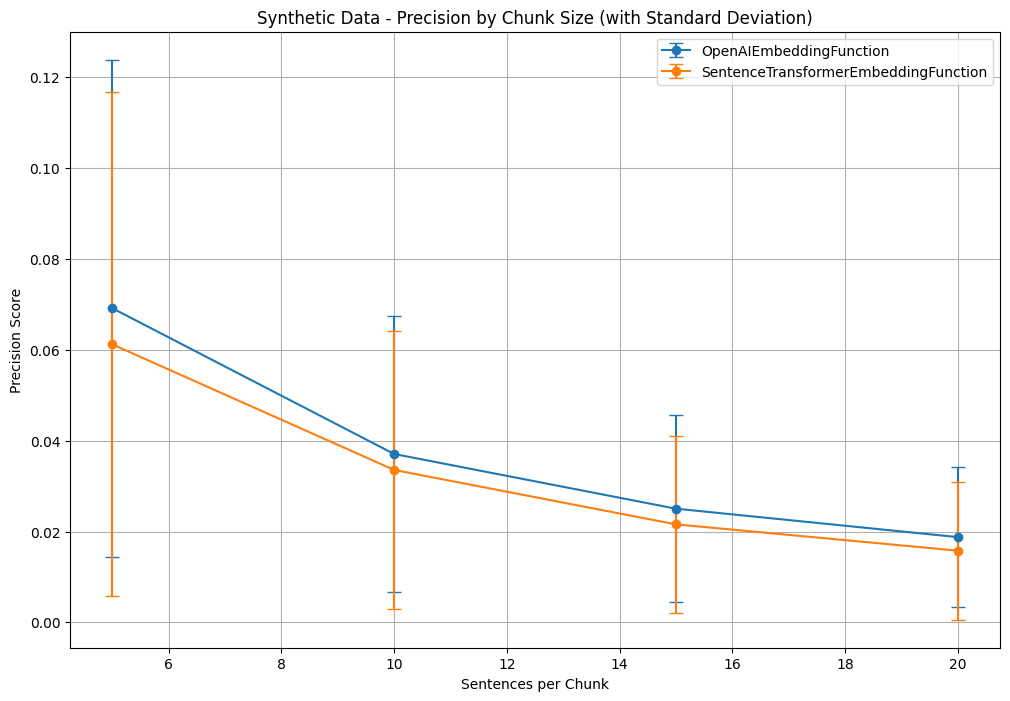

In [52]:
# Group data by embedding function
embedding_groups = synth_df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['precision_mean'],
                 yerr=group['precision_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("Precision Score")
plt.title("Synthetic Data - Precision by Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();


## Plot IoU by Chunk Size -- Synthetic Data

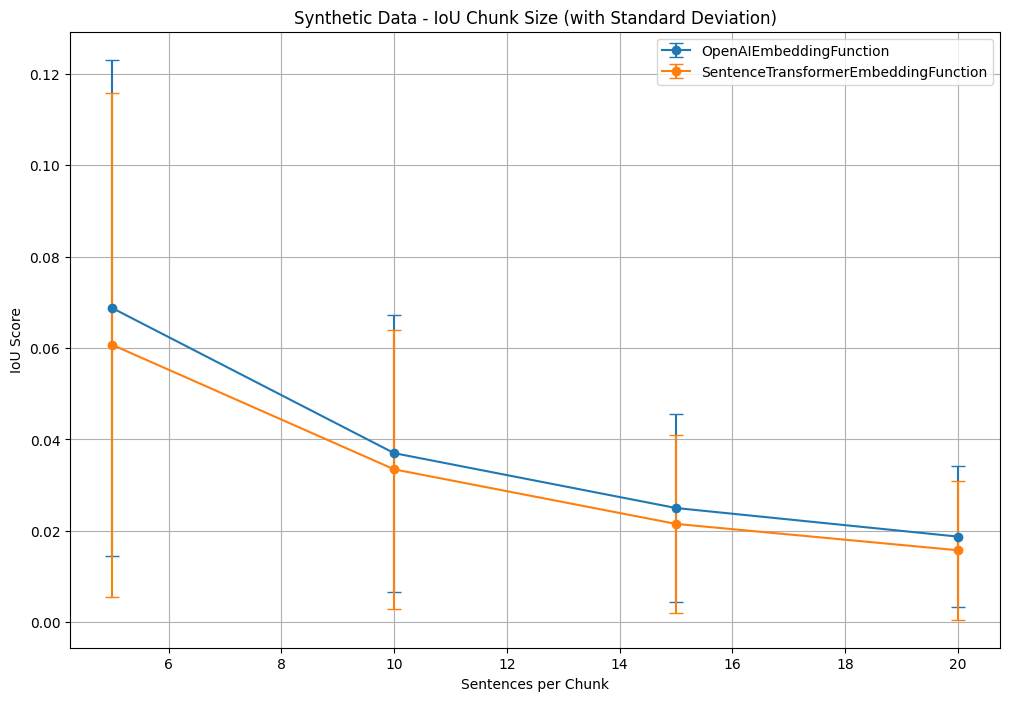

In [53]:
# Group data by embedding function
embedding_groups = synth_df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['iou_mean'],
                 yerr=group['iou_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("IoU Score")
plt.title("Synthetic Data - IoU Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();


## Plot Precision Omega by Chunk Size -- Synthetic Data

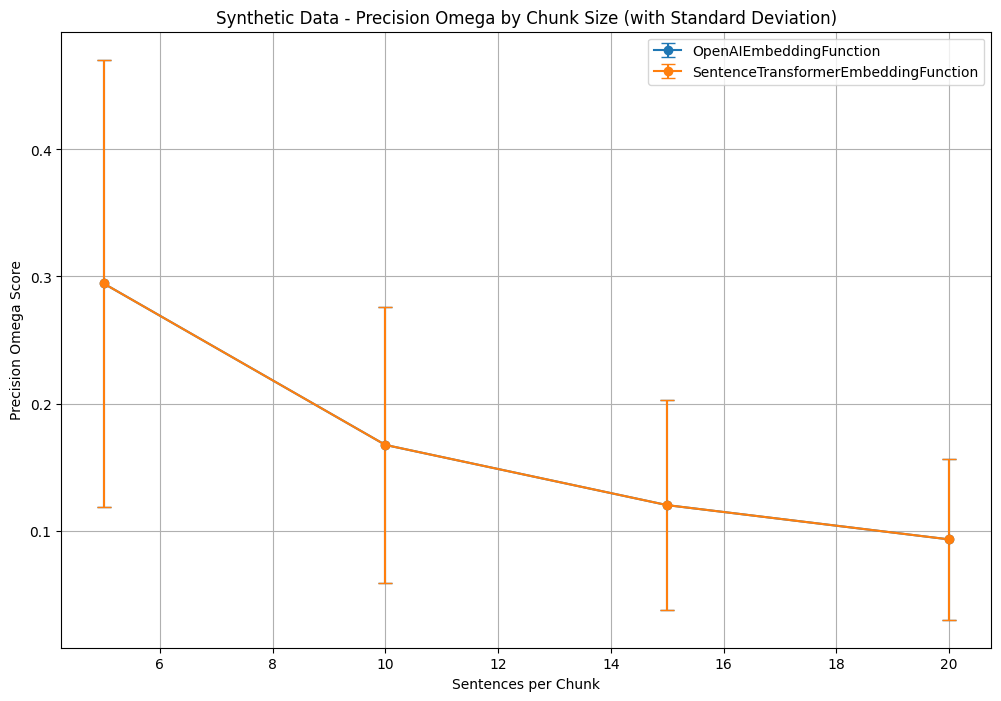

In [54]:
# Group data by embedding function
embedding_groups = synth_df.groupby('embedding_function')

# Create the plot
fig = plt.figure(figsize=(12, 8))

# Loop through df
for name, group in embedding_groups:
    plt.errorbar(group['chunk_size'],
                 group['precision_omega_mean'],
                 yerr=group['precision_omega_std'],  # Add this line for standard deviation
                 label=name,
                 marker='o',
                 capsize=5)  # capsize adds caps to the error bars

plt.xlabel("Sentences per Chunk")
plt.ylabel("Precision Omega Score")
plt.title("Synthetic Data - Precision Omega by Chunk Size (with Standard Deviation)")
plt.legend()
plt.grid(True)
plt.show();

Summary
* Overall the results were very similar for the synthetic data with some increase in the gap by the Open AI embedding model in terms of recall and precision.
* Overall we would need to take a much closer look at:

1. Embeddings used and compare them head to head to find the best embedding for our data.

2. Compare different chunking techniques and chunk sizes.

However, we were able to see how powerful this technique can be for evaluating chunking and embeddings in a RAG-LLM pipeline.

# Summary

* Chroma's RAG research framework provides a very useful and powerful toolset for evaluating and optimizing RAG systems through careful analysis of **chunking and embedding strategies.**

* Using Chroma's techniques, we were able to reveal several key insights:

1. **Chunking Strategy Impact**
  * The evaluation demonstrated how different chunking approaches can dramatically affect retrieval performance.
  * Smaller chunks (e.g. 5 sentences) consistently showed **higher precision** but at the cost of potentially fragmenting related content.
  * Larger chunks (e.g. 15-20 sentences) achieved better recall but with more noise.
  * Future experiments should compare various chunking strategies and with different size documents.


2. **Embedding Model Comparison**
  * The experiments showed the performance gap between state-of-the-art models (OpenAI's text-embedding-3-large) and lighter-weight alternatives (e.g. SentenceTransformer).
  * This helps quantify the tradeoff between cost/speed and performance when choosing embedding models.
  * However, we should also remember that embedding model evaluation is really an entire realm within its own right.
    * There are multiple ways to specifically test embedding models and it starts by looking at the MTEB - Massive Text Embedding Model Benchmark.

3. **Domain Specific Adaptation**
  * Synthetic dataset generation pipeline above revealed how general-purpose chunking strategies might need adjustment for specific document types.
  * In this experiment we used financial documentation from NVIDIA's 10-K.
  * This showed different optimal chunking parameters compared to the general evaluation corpus, highlighting **the importance of domain-specific tuning.**

4. **Metric Tradeoffs**
  * One of the main takeaways from this metric driven evaluation of RAG chunking is that we observed there is a **fundamental tension between precision and recall.**
  * We also saw that **IoU provides a balanced perspective on overall performance.**
  * These metrics can help guide data scientists in practical decision making and problem solving with chunk size and strategy based on specific use case requirements. Every domain will have a different result.
  * Metrics also give us a baseline as with any machine learning problem.

# Future Directions

Overall, the ChromaDB framework provides a **systematic, repeatable, and evidence-based approach** to developing and testing RAG systems.

* This allows data scientists to make data-driven decisions in regards to RAG-LLM pipelines. While there are open and closed source frameworks for evaluating RAG-LLM pipelines (e.g. LangSmith, Phoenix, DeepEval, Ragas, etc.), it is helpful to have a more mathematical and scientific approach to evaluation which this provides us.


* Future work experiments and implementations should include:

1. Multiple chunking strategies optimized for specific document types
  * Domain specific
  * Data specific (e.g. PDF, markdown, etc.)

2. Testing Different preprocessing steps and how this could improve retrieval performance.

3. While this technique focused on chunks and embeddings, it would also be helpful to add additional RAG driven testing such as:
  * Vector databases and their various algorithms (e.g. HNSW, ANN, IVF)
  * Cross-encoders with reranking
  * Late-chunking (mentioned above)
  * Contextual Retrieval
  * ....and other common RAG strategies.